### todo
- need to check that timestamp is monotonically increasing
- derive speech duration from timestamp (after checking and correcting if need be)
- fill missing timestamps by taking time between the next ones, then allocating to ones in between with missing based on word/character count
- [x] check speakers (then maybe exclude "Computer")
- [x] clean "[inaudible]", "[crosstalk]", "[foreign language]", also (*)
- check for special character to see for other things that need to be potentially cleaned


# speech preprocessing

- lowercase everything
- tokenization (words, punctuation)
- parts of speech (noun, verb etc.)
- lemmatization (thought -> think)
- remove stopwords (a, the, etc)
- pointwise mutual information (euro group -> euro_group)

In [4]:
import re
import time

import numpy as np
import pandas as pd

In [5]:
#import nltk
#nltk.download('stopwords')

In [6]:
df = pd.read_csv('data/euroleaks/prepared.csv')
df.head()

,speaker,speech,timestamp,date
0,Jeroen Dijsselbloem,… of your responses or questions. And can I fi...,1900-01-01 00:00:00,2015-02-24 00:00:00
1,Speaker 2,"Uh, yes, uh, thank you, Jeroen. Well, uh, comm...",1900-01-01 00:00:10,2015-02-24 00:00:00
2,Michael Noonan,Michael Noonan.,1900-01-01 00:01:27,2015-02-24 00:00:00
3,Speaker 2,"Uh, it is therefore regrettable that, uh-",1900-01-01 00:01:29,2015-02-24 00:00:00
4,Speaker 3,Has entered the conference.,1900-01-01 00:01:33,2015-02-24 00:00:00


## preliminary cleaning
- make all speech lowercase
- remove "Has entered the conference."
- remove speaker computer

In [7]:
# lowercase speech
df.speech = df.speech.apply(lambda s: s.lower())

In [8]:
# clean speaker

# strip and make lowercase
df.speaker = df.speaker.apply(lambda s: s.strip().lower() if not pd.isnull(s) else s)

# handle missing (only one)
df.speaker.loc[df.speaker.isnull()] = 'jeroen dijsselbloem'

# drop transcription artifact speaker
df = df[df.speaker != 'group']
df = df[df.speaker != 'inaudible']

# drop comuter generated speech
df = df[df.speech != 'Has entered the conference.']

# make names unique
amend_names = {
    'wolfgang schäuble': [
        'wolfgang schäuble',
        'wolfgang schauble',
        'wolfgang'
    ],
    'peter kažimír': [
        'peter kažimír',
        'peter kazimir'
    ],
    'michel sapin': [
        'michel sapin',
        'michel'
    ],
    'maria luís albuquerque': [
        'maria luís albuquerque',
        'maria luís',
        'maria luis albuquerque'
    ],
    'johan van overtveldt': [
        'johan van overtveldt',
        'johan'
    ],
    'benoît cœuré': [
        'benoît cœuré',
        'benoit couré',
        'benoit cœuré'
    ],
    'hans jörg schelling': [
        'hans jörg schelling',
        'hans'
    ],
    'poul mathias thomsen': [
        'paul thomsen',
        'paul',
        'poul thomsen'
    ],
    'yanis varoufakis': [
        'yanis varoufakis',
        'yanis varoufakis [privately]'
    ],
    'luis de guindos': [
        'luis de guindos',
        'luis'
    ],
    'irina': [
        'irina',
        'irana'
    ],
    'jānis reirs': [
        'yanis [not varoufakis]'
    ],
    'luca antonio ricci': [
        'ricci'
    ],
    'thomas steffen': [
        'thomas'
    ]
}

# invert dict
amend_names_inv = {value: key for key,values in amend_names.items() for value in values}

# amend speaker names
df.speaker = df.speaker.apply(lambda s: amend_names_inv[s] if s in amend_names_inv.keys() else s)

In [9]:
df.head()

,speaker,speech,timestamp,date
0,jeroen dijsselbloem,… of your responses or questions. and can i fi...,1900-01-01 00:00:00,2015-02-24 00:00:00
1,speaker 2,"uh, yes, uh, thank you, jeroen. well, uh, comm...",1900-01-01 00:00:10,2015-02-24 00:00:00
2,michael noonan,michael noonan.,1900-01-01 00:01:27,2015-02-24 00:00:00
3,speaker 2,"uh, it is therefore regrettable that, uh-",1900-01-01 00:01:29,2015-02-24 00:00:00
4,speaker 3,has entered the conference.,1900-01-01 00:01:33,2015-02-24 00:00:00


## regex: remove paranthesis and brackets
Numbers can be better filtered out using POS (parts of speech).

In [10]:
brackets = []

for s in df.speech:
    pattern = re.compile('\[\w*\]')
    found = pattern.search(s)
    if found:
        brackets.append(found.group())

np.unique(brackets)

array(['[]', '[affirmative]', '[bang]', '[bonds]', '[crosstalk]',
       '[french]', '[in]', '[inaudible]', '[laughs]', '[laughter]',
       '[measures]', '[silence]'], dtype='<U13')

In [11]:
paranthesis = []

for s in df.speech:
    pattern = re.compile('\(.*\)')
    found = pattern.search(s)
    if found:
        paranthesis.append(found.group())

np.unique(paranthesis)

array(['(06:45)', '(07:36)', '(08:14)', '(09:08)', '(13:07)', '(21:35)',
       '(22:25)', '(22:58)', '(29:07)', '(30:57)', '(35:39)',
       '(affirmative)', '(crosstalk)', '(foreign [language)',
       '(inaudible greetings)', '(inaudible)',
       '(inaudible) and also the [bonds] recapitalization requirements for the new program, so when you combine the two facts {inaudible] this results (crosstalk 12:26)',
       '(laughing)', '(laughs)', '(nse)', '(silence)'], dtype='<U160')

In [12]:
import re

def remove_brackets(sentence):
    brackets_ = re.compile('\[.*\]')
    return re.sub(brackets_, '', sentence)

def remove_paranthesis(sentence):
    paranthesis_ = re.compile('\(.*\)')
    return re.sub(paranthesis_, '', sentence)

In [13]:
df.speech = df.speech.apply(lambda s: remove_brackets(remove_paranthesis(s)))

## the "aide memoire" case
This term proved to be important while investigating bigram collocations.

https://en.wikipedia.org/wiki/Aide-m%C3%A9moire

In [14]:
def aide_memoire(s):
    """Replaces all of:
        'aid memoire'
        'aide memoir'
        'aide memoire'
        'aide -memoire'
        'aide-memoir'
        'aide-memoire'
    with 'aide memoire'.
    """
    pattern = re.compile('(aide{0,1} {0,1}( |-)memoire{0,1})')
    return re.sub(pattern, 'aide memoire', s)

In [15]:
df.speech = df.speech.apply(lambda s: aide_memoire(s))

In [16]:
df_prepared = df.copy()

## combine all speech to a single document

In [23]:
# lower-case everything, combine to single string
raw_doc = ' '.join(df.speech.apply(lambda s: s.lower()))

In [24]:
len(raw_doc)

503966

## tokenization
- https://spacy.io/models

In [25]:
import spacy

In [26]:
nlp = spacy.load("en_core_web_sm", exclude=["ner"])

t = time.time()
doc = nlp(raw_doc) # takes a few minutes
print(f'Time taken: {round((time.time() - t) / 60, 2)} mins')

Time taken: 2.82 mins


In [ ]:
tokens = [[ token.text for token in sentence] for sentence in doc.sents]

In [ ]:
#tokens[:5]

In [ ]:
c = 0
for t in tokens:
    c += len(t)
print(c)

## lemmatization and POS tagging

In [ ]:
lemmas = [[token.lemma_ for token in sentence] for sentence in doc.sents]

In [ ]:
#lemmas

In [ ]:
foo = [[(token.lemma_, token.pos_) for token in sentence] for sentence in doc.sents]

In [ ]:
for f in foo[1]:
    print(f)

## stopwords

In [27]:
# make stopwords out of names
stopnames = []

for names in amend_names.values():
    for name in names:
        if not re.search('\[.*\]', name):
            stopnames += name.split(' ')
            
for name in df.speaker.unique():
    if 'speaker' not in name:
        stopnames += name.split(' ')
    
stopnames = set(stopnames)

In [ ]:
content = [[token.text for token in sentence if 
            not token.is_stop and
            not token.text in stopnames
           ] for sentence in doc.sents]

In [ ]:
c = 0
for t in content:
    c += len(t)
print(c)

In [ ]:
#content

## named entities

In [ ]:
#entities = [[( entity.text , entity.label_)
#    for entity in nlp(sentence.text).ents]
#    for sentence in doc.sents]

#entities

## numbers
If not important, then either leave out with POS or replace with regex.

In [ ]:
import re

numbers = re.compile('[0-9]')
re.sub(numbers , '0', 'Back in the 90s, when I was a 12-year -old ,a CD cost just 15,99 EUR!')

## pointwise mutual information (collocations)
- https://www.nltk.org/howto/collocations.html
- mi_like score: https://www.nltk.org/api/nltk.metrics.html#nltk.metrics.association.NgramAssocMeasures.mi_like

In [28]:
def apply_trigram_colloc(s, set_colloc):
    res = s.lower()
    for b1,b2,b3 in set_colloc:
        res = res.replace(f'{b1} {b2} {b3}', f'{b1}_{b2}_{b3}')
    return res

def apply_bigram_colloc(s, set_colloc):
    res = s.lower()
    for b1,b2 in set_colloc:
        res = res.replace(f'{b1} {b2}', f'{b1}_{b2}')
    return res

#### trigrams

In [29]:
from nltk.collocations import TrigramCollocationFinder, TrigramAssocMeasures

# needs to be a one-dim list
# lemmatization, filter out punctuation and stop words
words = [token.lemma_ for sentence in doc.sents for token in sentence
            if token.pos_ in {'ADJ', 'ADV', 'NOUN', 'PROPN', 'VERB'}
            and not token.is_stop
            and not token.text in stopnames
            and len(token.text) > 1 # for punctuation (but also 'I')
        ]

finder = TrigramCollocationFinder.from_words(words)

# word might be highly correlated but very infrequent, ignore all with less than n occurances
finder.apply_freq_filter(5)

tgm = TrigramAssocMeasures()
collocations = {trigram: pmi for trigram, pmi in finder.score_ngrams(tgm.mi_like)}

In [30]:
collocations

{('euro', 'working', 'group'): 0.045454545454545456,
 ('comprehensive', 'valid', 'starting'): 0.027233115468409588,
 ('successful', 'conclusion', 'review'): 0.011784511784511785,
 ('low', 'interest', 'rate'): 0.010439612699499706,
 ('debt', 'sustainability', 'analysis'): 0.006432858214553638,
 ('valid', 'starting', 'point'): 0.006118453255017132,
 ('statement', '20th', 'february'): 0.005505095625703131,
 ('nominal', 'interest', 'rate'): 0.0030303030303030303,
 ('interest', 'rate', 'environment'): 0.0017536475869809204,
 ('list', 'prior', 'action'): 0.0015639581657280772,
 ('labor', 'market', 'reform'): 0.0015536554593193752,
 ('starting', 'point', 'successful'): 0.001529613313754283,
 ('staff', 'level', 'agreement'): 0.0012303485987696513,
 ('product', 'market', 'reform'): 0.0010193295077016006,
 ('set', 'prior', 'action'): 0.0009186602870813397,
 ('prior', 'action', 'list'): 0.00046339501206757845,
 ('discussion', 'brussel', 'group'): 0.0004310344827586207,
 ('low', 'low', 'pension'):

In [31]:
trigram_colloc = {('euro', 'working', 'group')}

words = apply_trigram_colloc(' '.join(words), trigram_colloc).split(' ')

#### bigrams

In [32]:
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
#from nltk.corpus import stopwords

#stopwords_ = set(stopwords.words('english'))

finder = BigramCollocationFinder.from_words(words)

# word might be highly correlated but very infrequent, ignore all with less than n occurances
finder.apply_freq_filter(5)

bgm = BigramAssocMeasures()
collocations = {bigram: pmi for bigram, pmi in finder.score_ngrams(bgm.mi_like)}

In [33]:
#collocations

In [34]:
threshold = 1

bigram_colloc_candidate = []
for bigram, score in collocations.items():
    if score > threshold:
        bigram_colloc_candidate.append(bigram)
    else:
        break
        
bigram_colloc_candidate = set(bigram_colloc_candidate)
bigram_colloc_candidate

{('20th', 'february'),
 ('aide', 'memoire'),
 ('anti', 'corruption'),
 ('brussel', 'group'),
 ('capital', 'control'),
 ('central', 'bank'),
 ('collective', 'bargaining'),
 ('common', 'ground'),
 ('debt', 'sustainability'),
 ('enter', 'conference'),
 ('govern', 'council'),
 ('growth', 'friendly'),
 ('half', 'percent'),
 ('interest', 'rate'),
 ('labor', 'market'),
 ('little', 'bit'),
 ('maximum', 'flexibility'),
 ('member', 'state'),
 ('minimum', 'wage'),
 ('primary', 'surplus'),
 ('prime', 'minister'),
 ('prior', 'action'),
 ('product', 'market'),
 ('second', 'letter'),
 ('smp', 'bond'),
 ('structural', 'reform'),
 ('successful', 'conclusion'),
 ('technical', 'team'),
 ('thank', 'thank'),
 ('valid', 'starting')}

In [35]:
bigram_colloc = {
    ('20th', 'february'),
    ('aide', 'memoire'),
    ('anti', 'corruption'),
    ('brussel', 'group'),
    ('capital', 'control'),
    ('central', 'bank'),
    ('collective', 'bargaining'),
    ('common', 'ground'),
    ('debt', 'sustainability'),
    ('govern', 'council'),
    ('growth', 'friendly'),
    ('interest', 'rate'),
    ('labor', 'market'),
    ('maximum', 'flexibility'),
    ('member', 'state'),
    ('minimum', 'wage'),
    ('primary', 'surplus'),
    ('prime', 'minister'),
    ('prior', 'action'),
    ('product', 'market'),
    ('second', 'letter'),
    ('smp', 'bond'),
    ('structural', 'reform'),
    ('successful', 'conclusion'),
    ('technical', 'team'),
    ('real', 'estate')
}

words = apply_bigram_colloc(' '.join(words), bigram_colloc).split(' ')

## consider doing token_POS so as to differentiate between eg. show_VERB and show_NOUN

## TF-IDF counts

Interpretation: Words that are moderately frequent but occur
in only a few documents get the highest score, and these words are what we
are after.

One document is one speech made by speaker.

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer

In [27]:
# join speech of consecutive rows with same speaker

df_squeezed = pd.DataFrame(columns=['speaker','speech','date'])

previous_speaker = None
speech = None
previous_date = None

for index, data in df.iterrows():
    
    if not previous_speaker and not speech and not previous_date:
        previous_speaker = data.speaker
        speech = data.speech
        previous_date = data.date
    elif data.speaker == previous_speaker and previous_date == data.date:
        speech = ' '.join((speech, data.speech))
    else:
        df_squeezed.loc[len(df_squeezed.index)] = [
            previous_speaker,
            speech,
            previous_date
        ]
        previous_speaker = data.speaker
        speech = data.speech
        previous_date = data.date

In [28]:
# lowercase
raw_documents = df_squeezed.speech.apply(lambda s: s.lower()).to_numpy()

#filter_POS = {'ADJ', 'ADV', 'NOUN', 'PROPN', 'VERB'}
filter_POS = {'NOUN'}

documents = [
    ' '.join([f'{token.lemma_}_{token.pos_}' for sentence in nlp(doc).sents for token in sentence
            if token.pos_ in filter_POS
            and not token.is_stop
            and not token.text in stopnames
            and len(token.text) > 1
    ])
    for doc in raw_documents 
]

In [29]:
print(f'There are {len(documents)} documents.')

There are 784 documents.


In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(analyzer='word',
                                   min_df =0.001,
                                   max_df =0.75,
                                   #stop_words='english',
                                   sublinear_tf=True)

X = tfidf_vectorizer.fit_transform(documents)                                  

In [31]:
idf = tfidf_vectorizer.idf_
tfidf = X.sum(axis =0).A1

In [32]:
# get tf
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(analyzer='word',
                                   min_df =0.001,
                                   max_df =0.75)
                                   #stop_words='english')

X_ = count_vectorizer.fit_transform(documents)

assert np.array_equal(
    count_vectorizer.get_feature_names(),
    tfidf_vectorizer.get_feature_names()
)

tf = X_.toarray().sum(axis=0)

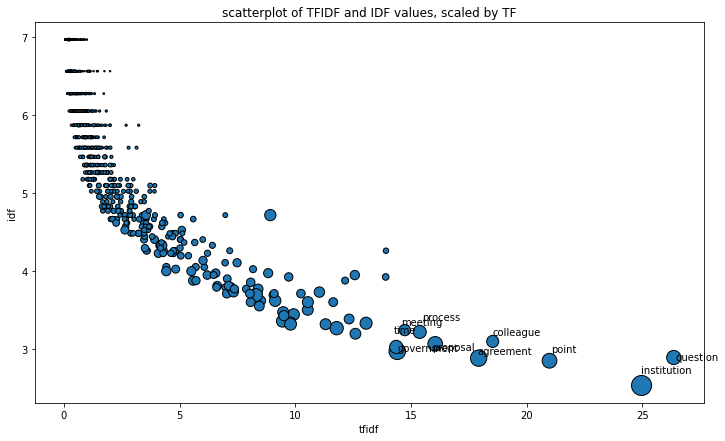

In [33]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,7))
ax.scatter(tfidf, idf, s=tf, edgecolors='black', label='tfidf')
#ax.legend()
ax.set_xlabel('tfidf')
ax.set_ylabel('idf')
ax.set_title('scatterplot of TFIDF and IDF values, scaled by TF')

# annotate words with highest tfidf
first_k = 10
sort_ix = np.argsort(tfidf)[::-1]
for ix in sort_ix[:first_k]:
    s = tfidf_vectorizer.get_feature_names()[ix].split('_')[0]
    jiggle_x = np.random.normal(0,0.1)
    jiggle_y = np.random.normal(0,0.1)
    ax.text(tfidf[ix]+jiggle_x, idf[ix]+jiggle_y, s)

In [591]:
for word in np.array(tfidf_vectorizer.get_feature_names())[sort_ix][:10]:
    print(word.split('_')[0])

question
institution
point
colleague
agreement
proposal
process
meeting
government
time


## bag of words non-negative matrix factorization

Maybe rather use it to visualize BOW (bag of words) for leaks vs communiques, where one document is either one leaked conference (df.groupby('date')) or one communique.

But note the preprocessing: stopwords removed, filtered on POS, collocations...

- [ ] inspect error score (explain why you use two cluster, try with more)
- [ ] try more cluster than two

try all dims, ccluster, compute cluster separation measure

## NMF document clustering
- [ ] get term-document matrix
    - params: min_df, max_df, etc.
- [ ] tf-idf term weighting
- NMF
    - [ ] try number of clusters k={2..n_speakers}
    - [ ] collect reconstruction error for each k and plot
    - [ ] use elbow method to determine k
    - [ ] try different error functions (need to read on this)
    - beware of max_iter and tol params when comparing reconstruction error for different k's
- [ ] pick keywords, then plot heatmap keywords/clusters
    - maybe use averged score of word for documents (speakers) belonging to that cluster
    - maybe name clusters by most prominent speakers of that cluster    
- [ ] try the same pipeline with bigrams and trigrams

In [85]:
df = df_prepared.copy()
# apply collocations
df.speech = df.speech.apply(lambda s: apply_trigram_colloc(s, trigram_colloc))
df.speech = df.speech.apply(lambda s: apply_bigram_colloc(s, bigram_colloc))

In [86]:
grouped = df.drop(columns=['timestamp','speaker']).groupby('date').apply(lambda s: ' '.join(s.speech))

In [87]:
grouped.head()

date
2015-02-24 00:00:00    … of your responses or questions. and can i fi...
2015-03-17 00:00:00    … coming in the next eh, in the next days and ...
2015-04-01 00:00:00    also uh have a discussion on the hfsf buffer a...
2015-04-24 00:00:00    uh, pierre, , welcome. thank you for joining u...
2015-05-11 00:00:00    … closely and they’re supposed to conclude the...
dtype: object

In [88]:
speakers = grouped.index

In [89]:
filter_POS = {'ADJ', 'ADV', 'NOUN', 'PROPN', 'VERB', 'ADP'}

documents = [
    ' '.join([f'{token.lemma_}_{token.pos_}' for sentence in nlp(doc).sents for token in sentence
            if token.pos_ in filter_POS
            and not token.is_stop
            and not token.text in stopnames
            and len(token.lemma_) > 1
    ])
    for doc in grouped.values 
]

In [90]:
np.unique(' '.join(documents).split()).size

3865

Get the document-term matrix.
One row per document and one column per token.

In [91]:
#from sklearn.feature_extraction.text import CountVectorizer

#count_vectorizer = CountVectorizer(analyzer='word',
#                                   min_df =0.001,
#                                   max_df =0.75)

#X = count_vectorizer.fit_transform(documents)

#print(X.shape)

In [92]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(analyzer='word',
                                   min_df=2, # word has to be in at least two documents
                                   max_df=0.95, # word has to be in less the 95% of documents
                                   smooth_idf=True, # Smooth idf weights by adding one to document frequencies, as if an extra document was seen containing every term in the collection exactly once. Prevents zero divisions.
                                   sublinear_tf=False) # replace tf with 1 + log(tf).

X = tfidf_vectorizer.fit_transform(documents)  

In [93]:
from sklearn.decomposition import NMF

reconstruction_error = []
for k in range(2, len(speakers)+1):
    
    nmf = NMF(n_components=k,
              init='nndsvd',
              beta_loss='frobenius',
              max_iter=1000,
              random_state=0,
              alpha=0,
              l1_ratio=0)
    
    nmf.fit(X.toarray())
    
    reconstruction_error.append(nmf.reconstruction_err_)
    #print(f'{k} - iterations: {nmf.n_iter_}')


#W = nmf.fit_transform(X.toarray())
#H = nmf.components_

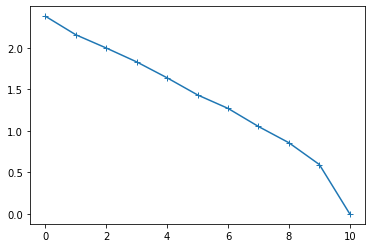

In [94]:
plt.plot(reconstruction_error, marker='+')

In [95]:
nmf = NMF(n_components=2,
          init='nndsvd',
          beta_loss='frobenius',
          max_iter=1000,
          random_state=0,
          alpha=0,
          l1_ratio=0)

W = nmf.fit_transform(X.toarray())
H = nmf.components_

print(f'W shape: {W.shape}')
print(f'H shape: {H.shape}')

W shape: (12, 2)
H shape: (2, 1885)


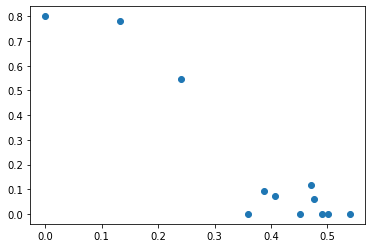

In [96]:
plt.scatter(W[:,0], W[:,1])

In [50]:
#plt.matshow(W[:4,:])#, cmap='Greys')

[-0.00290221  0.00468495]


Text(0.5, 1.0, 'bag of words NNMF')

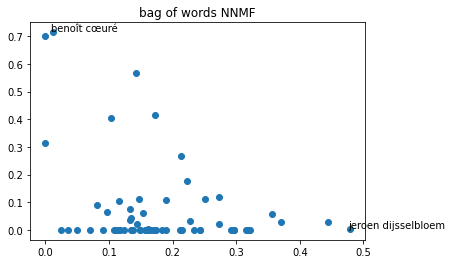

In [84]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.scatter(W[:,0], W[:,1])

outlier_x = np.argmax(W[:,0])
outlier_y = np.argmax(W[:,1])

jiggle = np.random.normal(0,0.005,2)
print(jiggle)
ax.text(W[:,0][outlier_x]+jiggle[0], W[:,1][outlier_x]+jiggle[1], speakers[outlier_x])
ax.text(W[:,0][outlier_y]+jiggle[0], W[:,1][outlier_y]+jiggle[1], speakers[outlier_y])

ax.set_title('bag of words NNMF')

Text(0.5, 1.0, 'bag of words NNMF')

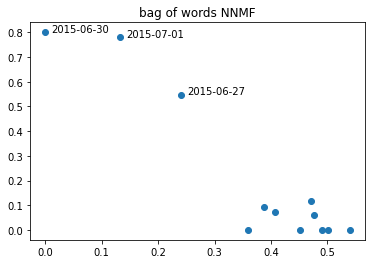

In [99]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.scatter(W[:,0], W[:,1])


outliers = np.argsort(W[:,1])[::-1][:3]

jiggle = np.random.normal(0,0.005,2)

for outlier in outliers:
    ax.text(W[:,0][outlier]+jiggle[0], 
            W[:,1][outlier]+jiggle[1], 
            speakers[outlier].split()[0])

ax.set_title('bag of words NNMF')

In [52]:
df_outliers = pd.DataFrame({
    speakers[np.argmax(H[0])]: [w.split('_')[0] for w in np.array(count_vectorizer.get_feature_names())[W[:,0] > np.percentile(W[:,0], 99)]],
    speakers[np.argmax(H[1])]: [w.split('_')[0] for w in np.array(count_vectorizer.get_feature_names())[W[:,1] > np.percentile(W[:,1], 99)]]
})

df_outliers

,yanis varoufakis,jeroen dijsselbloem
0,agree,agree
1,agreement,agreement
2,ask,ask
3,believe,authority
4,colleague,clear
5,come,colleague
6,eurogroup,come
7,go,conclusion
8,government,course
9,greece,eurogroup


## word embeddings
Modern embedding models define context as a local window to either
side of the target word (not whole document).
- word2vec (convention ndim=300)

two main architectures:
- **continuous bag of words** (CBOW): predict output word from input of context words (local neighbourhood)
- **skipgram**: predit cintext word output from target word input

Either used pretrained, train yourself from scratch, or transfer learning.

When training, best to train multiple models on same data and average them.

- also see doc2vec

If we are interested
in general societal attitudes, or if we have tiny data sets, these pretrained
embeddings are a great starting point.
In other cases, we might want to train embeddings on our corpus ourselves,
to capture the **similarities which are specific to this data collection**. In the latter
case, we can use the word2vec implementation in the gensim library.

In [35]:
# apply collocations
df.speech = df.speech.apply(lambda s: apply_trigram_colloc(s, trigram_colloc))
df.speech = df.speech.apply(lambda s: apply_bigram_colloc(s, bigram_colloc))

In [36]:
# lower-case everything, combine to single string
raw_doc = ' '.join(df.speech.apply(lambda s: s.lower()))

In [47]:
nlp = spacy.load("en_core_web_sm")

t = time.time()
doc = nlp(raw_doc) # takes a few minutes
print(f'Time taken: {round((time.time() - t) / 60, 2)} mins')

Time taken: 1.69 mins


In [49]:
#words_test = [token.lemma_ for sentence in doc.sents for token in sentence
#            if token.pos_ in {'NUM'}
#            and not token.is_stop
#            and not token.text in stopnames
#            and len(token.text) > 1 # for punctuation (but also 'I')
#        ]
#
#words_test

In [50]:
#for row in df.iterrows():
#    if '20th_february' in row[1].speech:
#        print(row[1].speaker)
#        print(row[1].speech)
#        print()

In [51]:
# list of lists of words
corpus = [[f'{token.lemma_}_{token.pos_}' for token in sentence
            if token.pos_ in {'ADJ', 'ADV', 'NOUN', 'PROPN', 'VERB', 'ADP'}
            and not token.is_stop
            and not token.text in stopnames
            and len(token.text) > 1 # for punctuation (but also 'I')
          ] for sentence in doc.sents
        ]

In [141]:
print(len(corpus))

4554


In [60]:
# check average number of words in sentence to inform choice of window size
pd.Series([len(sent) for sent in corpus]).describe()

count    4554.000000
mean        6.802591
std         6.231276
min         0.000000
25%         2.000000
50%         5.000000
75%        10.000000
max        57.000000
dtype: float64

In [169]:
from gensim.models import Word2Vec
from gensim.models.word2vec import FAST_VERSION

# initialize model
w2v_model = Word2Vec(size =300,
                    window=3,
                    sample=1e-5,
                    negative=5,
                    min_count=10,
                    #alpha=0.03,
                    #min_alpha=0.000007,
                    workers=-1,
                    iter=10000
)

In [170]:
w2v_model.build_vocab(corpus)

In [171]:
t = time.time()
w2v_model.train(corpus, total_examples=w2v_model.corpus_count, epochs=w2v_model.epochs)
print(f'Time taken: {round((time.time() - t) / 60, 2)} mins')

Time taken: 1.41 mins


In [293]:
for word in w2v_model.wv.vocab.keys():
    if 'bond' in word:
        print(word)

bond_NOUN


In [592]:
keywords = [
    'greece_NOUN',
    'institution_NOUN',
    'imf_NOUN',
    'ecb_NOUN',
    'commission_NOUN',
    'government_NOUN',
    'referendum_NOUN',
    'mou_NOUN',
    'debt_NOUN',
    'debt_sustainability_NOUN',
    'pension_NOUN',
    'bank_NOUN',
    'bond_NOUN',
    'crisis_NOUN'
]

df_closest = pd.DataFrame({word.split('_')[0]: [n.split('_')[0] for n,score in w2v_model.wv.most_similar(word)] for word in keywords})
df_closest

,greece,institution,imf,ecb,commission,government,referendum,mou,debt,pension,bank,bond,crisis
0,principle,fair,great,deal,sure,decide,call,call,direction,ahead,assistance,late,beginning
1,hour,imf,say,probably,possibility,recall,lose,long,summit,arrangement,good,rest,risk
2,tax,focus,plan,well,recommend,union,clearly,make,mean,funding,lack,effect,focus
3,possibly,legislation,commission,right,imf,true,moment,start,confirm,begin,effect,stage,finally
4,press,deposit,mandate,work,service,politically,improve,raise,relate,convergence,common,year,couple
5,create,plan,impossible,have,consequence,instead,bit,word,concern,concern,briefly,maintain,one
6,meet,system,benefit,point,undertake,fund,proceed,feel,meeting,maybe,set,commitment,take
7,recessionary,parliament,minute,hour,govern,compare,carry,one,talk,try,right,second,minister
8,look,eurogroup,arrangement,nominal,bill,monetary,procedure,stance,long,maintain,respond,economy,greece
9,crisis,commitment,collect,concrete,old,cover,measure,month,sufficiently,approach,sure,area,private


In [298]:
word1 = "greece_NOUN"
word2 = "accept_VERB"

# retrive the actual vector
#w2v_model.wv[word1]

# compare
#w2v_model.wv.similarity(word1 , word2)

# get the 3 most similar words
#w2v_model.wv.most_similar(positive=[word1])

### PCA + t-SNE visualization

In [176]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [306]:
def tsnescatterplot(model, word1, word2, colors):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    
    # word1
    word_labels = [word1]
    color_list  = [colors[0]]
    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word1]), axis=0)
    
    # closest of word1
    close_words = model.wv.most_similar([word1])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append(colors[1])
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # word2
    word_labels.append(word2)
    color_list.append(colors[2])
    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word2]), axis=0)
    
    # closest of word2
    close_words = model.wv.most_similar([word2])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        # special color if both search words share closest
        if wrd_score[0] in word_labels:
            color_list.append(colors[-1])
        else:
            color_list.append(colors[3])
        word_labels.append(wrd_score[0])
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    print(arrays.shape)
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    pca = PCA(n_components=2)
    reduc = pca.fit_transform(arrays)
    #print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
    print(reduc.shape)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, perplexity=15, n_iter=20000).fit_transform(reduc)
    print(Y.shape)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(12, 12)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].split('_')[0],
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title(f't-SNE visualization for closest neighbors of {word1.split("_")[0]} and {word2.split("_")[0]}')

In [424]:
colors = np.array(sns.color_palette("hls", 8))[np.array([0,1,6,7,4])]

(22, 300)
(22, 2)
(22, 2)


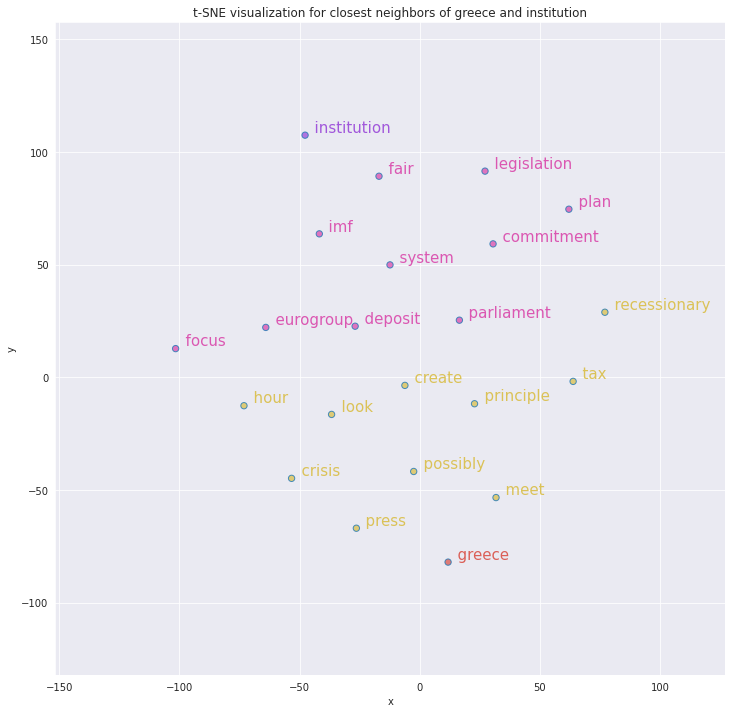

In [308]:
tsnescatterplot(w2v_model, 'greece_NOUN', 'institution_NOUN', colors=colors)

## document embeddings
Document = speaker.

- [ ] maybe use national debt levels in 2015 for retrofitting or structure (when clustering)
- [ ] use agglomerative clustering instead of k-means

In [479]:
df = df_prepared.copy()
# apply collocations
df.speech = df.speech.apply(lambda s: apply_trigram_colloc(s, trigram_colloc))
df.speech = df.speech.apply(lambda s: apply_bigram_colloc(s, bigram_colloc))

In [480]:
# missing:
# estonia (Maris Lauri, Sven Sester)
# luxembourg (Pierre Gramegna)


speaker_to_entity = {
    'jeroen dijsselbloem': 'eurogroup president', # the netherlands
    'michael noonan': 'ireland',
    'pierre moscovici': 'european commission',
    'mario draghi': 'ecb',
    'wolfgang schäuble': 'germany',
    'thomas steffen': 'germany', # State Secretary at the Federal Ministry of Finance under Schauble
    'christine lagarde': 'imf',
    'yanis varoufakis': 'greece',
    'luis de guindos': 'spain',
    'maria luís albuquerque': 'portugal',
    'marco buti': 'european commission',
    'thomas wieser': 'efc', # economic and financial committee
    'declan costello': 'european commission', #dg ecfin
    'benoît cœuré': 'ecb',
    'poul mathias thomsen': 'imf',
    'greek representative': 'greece',
    'nikos theocarakis': 'greece',
    'hans jörg schelling': 'austria',
    'klaus regling': 'esm', # head of european stability mechanism
    'peter kažimír': 'slovakia',
    'dušan mramor': 'slovenia',
    'michel sapin': 'france',
    'translator': 'france',
    'pier carlo padoan': 'italy',
    'edward scicluna': 'malta',
    'rimantas šadžius': 'lithuania',
    'alexander stubb': 'finland', # from May 29
    'tooma': 'finland', # based on saying they have two and a half weeks until elections on April 1
    'johan van overtveldt': 'belgium',
    'harris georgiades': 'cyprus',
    'luis pierre': 'european commission',
    'jānis reirs': 'latvia',
    'luca antonio ricci': 'imf'
}

# add column for entity, label unassigned as unknown
df['entity'] = df.speaker.apply(lambda s: speaker_to_entity[s] if s in speaker_to_entity.keys() else 'unkown')

In [481]:
grouped = df.drop(columns=['timestamp','date','speaker']).groupby('entity').apply(lambda s: ' '.join(s.speech))

In [482]:
#grouped = df.drop(columns=['timestamp','date', 'entity']).groupby('speaker').apply(lambda s: ' '.join(s.speech))

In [483]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

nlp = spacy.load("en_core_web_sm")

documents = []

for entity, text in grouped.iteritems():
    
    doc = nlp(text)
    
    doc_ = [f'{token.lemma_}_{token.pos_}' for sentence in doc.sents for token in sentence
                if token.pos_ in {'ADJ', 'ADV', 'NOUN', 'PROPN', 'VERB'} # content words
                and not token.is_stop
                and not token.text in stopnames
                and len(token.text) > 1 # for punctuation (but also 'I')
            ]
    
    documents.append(TaggedDocument(doc_, tags=[entity]))

In [484]:
d2v_model = Doc2Vec(vector_size=300,
                    window=3,
                    sample=1e-5,
                    negative=5,
                    min_count=10,
                    #alpha=0.03,
                    #min_alpha=0.000007,
                    workers=-1,
                    epochs=10000,
                    dm=0,
                    dbow_words=1
)

In [485]:
d2v_model.build_vocab(documents)

In [486]:
d2v_model.train(documents, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)

In [487]:
print(f'There are {grouped.index.size} entities')

There are 23 entities


In [593]:
labels = grouped.index
arrays = np.empty((0, 300), dtype='f')

for label in labels:
    #print(d2v_model.docvecs[label].shape)
    arrays = np.append(arrays, d2v_model.docvecs[label].reshape((1,300)), axis=0)
    
pca = PCA(n_components=0.95)
reduc = pca.fit_transform(arrays)
print(reduc.shape)
#print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))


# CLUSTERING
from sklearn.cluster import KMeans
km = KMeans(n_clusters=2, max_iter=1000)
clusters = km.fit_predict(reduc)
centroids = km.cluster_centers_

color_palette = np.array(sns.color_palette("hls", 8))[np.array([0,5])]
colors = list(color_palette[clusters])
    
# Finds t-SNE coordinates for 2 dimensions
np.set_printoptions(suppress=True)
    
Y = TSNE(n_components=2, perplexity=15, n_iter=20000).fit_transform(reduc)
    
# Sets everything up to plot
df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                    'y': [y for y in Y[:, 1]],
                    'words': labels,
                    'color': colors})
    
fig, _ = plt.subplots()
fig.set_size_inches(9, 9)
    
# Basic plot
p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                        }
                    )
    
# Adds annotations one by one with a loop
for line in range(0, df.shape[0]):
     p1.text(df["x"][line],
             df['y'][line],
             '  ' + df["words"][line],
             horizontalalignment='left',
             verticalalignment='bottom', size='medium',
             color=df['color'][line],
             weight='normal'
            ).set_size(15)

    
#plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
#plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
#plt.title(f't-SNE visualization for closest neighbors of {word1.split("_")[0]} and {word2.split("_")[0]}')

KeyError: "tag 'alexander stubb' not seen in training corpus/invalid"

# communiques

In [ ]:
pd.read_csv('data/communiques/prepared.csv').sort_values(by='date').reset_index(drop=True)